In [5]:
%load_ext autoreload
%autoreload 2

In [2]:
import pathlib
import re

import copy

import numpy as np
import pandas as pd
import xarray as xr
xr.set_options(display_expand_data=False)

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook',palette='bright',style='ticks')

import tqdm

from scipy.stats import norm

%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
%config InlineBackend.figure_formats = ['svg']

In [3]:
from AFL.automation import prepare
from AFL.automation.APIServer import DummyDriver
from AFL.automation.shared.units import units,is_concentration,is_volume,is_mass
from AFL.agent.AgentClient import AgentClient
from AFL.agent import xarray_extensions, GaussianProcess
from AFL.agent import Metric,PhaseLabeler,AcquisitionFunction
from AFL.automation.APIServer.Client import Client

2024-02-10 09:27:59.350920: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-10 09:27:59.384021: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/root/miniforge3/envs/afl_agent/lib/python3.11/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar

In [4]:
from SAS_model_fit_driver import SAS_model_fit, sas_wrapper
import sasmodels

## Server instantiation

In [15]:
path = '//mnt/c/Users/drs18/Downloads/230530_AL_manifest-P188_2D_MultiModal_UCB_noThomp_FixedP188.nc'

In [119]:
netcdf_path = path
model_ds = xr.load_dataset(netcdf_path)

sasfit_url = 'localhost:5058'
sasfit_client = Client(sasfit_url.split(':')[0],port=sasfit_url.split(':')[1])
sasfit_client.login('SampleServer_SASfit_Client')
sasfit_client.debug(False)
sasfit_client.set_config(
    filepath='/Users/drs18/Documents/multimodal-dev/SAS_fitting_agent_dev/',
    save_path='/Users/drs18/Documents/multimodal-dev/SAS_fitting_agent_dev/',
    q_range = (model_ds.q.min().values.tolist(), model_ds.q.max().values.tolist()),
    model_inputs = [{
        'name':'power_law_1',
        'sasmodel':'power_law',
        'fit_params':{
            'power':{
                'value':4,
                'bounds':(3,4.5)
            },
            'background':{
                'value':1e-4,
                'bounds':(1e-10,1e2)
            },
            'scale':{
                'value':1e0,
                'bounds':(1e-6,1e4)
            }
        }
    }]
)


UUID('c23348d8-065b-4b5a-a3ab-e53136ae4f7e')

## test startup and base functions

In [150]:
sasfit_client.enqueue(task_name='construct_models')

UUID('1a3c9f3f-8c36-41a3-be3e-507d1b987211')

In [238]:
config = sasfit_client.get_config('all',interactive=True)

In [239]:
dummy_model = config['return_val']['model_inputs'][0]
add_model = dummy_model
# print(add_model)
add_model['name'] = 'power_law_2'
add_model['fit_params']['power'] = {'value':2, 'bounds':[1,3]}
sasfit_client.enqueue(task_name='add_model',model_dict=[add_model])

add_model['name'] = 'power_law_3'
add_model['fit_params']['power'] = {'value':800, 'bounds':[100,1000]}
sasfit_client.enqueue(task_name='add_model',model_dict=[add_model])


UUID('f14a9410-9839-4865-b566-1ba0316da4fd')

In [240]:
sasfit_client.enqueue(task_name='remove_model',name='power_law_3')

UUID('9473a90e-6b59-4595-a4e2-459e00e35672')

## Test on real data with fitting

In [120]:
data = []
for idx in range(len(model_ds.SAS)):
    
    q = model_ds.q.values#[:-25]
    I = model_ds.SAS[idx].values#[:-25]
    dI = 0.1 * I
    data.append(np.vstack([q,I,dI]).T.tolist())
# data = sasmodels.data.Data1D(x=q,y=I,dy=dI) 
initial_models = [
    {'name':"polymer_micelle_1",
     'sasmodel':'polymer_micelle',
     'fit_params':{
            "scale"       : {'value':2*max(I), 'bounds':(1e-1,1e4)},
            "background"  : {'value':50,       'bounds':(1e-1,1e4)},
            "radius_core" : {'value':40,       'bounds':(1e-1,1e4)},
            "rg"          : {'value':60,       'bounds':(1e-1,1e4)},
            "sld_core"    : {'value':5.45,     'bounds':None},
            "sld_corona"  : {'value':5.15,     'bounds':None},
            "sld_solvent" : {'value':6.36,     'bounds':None},
     }
    },
    {'name':"small_sphere_1",
     'sasmodel':'sphere',
     'fit_params':{
            "scale"       : {'value':max(I),   'bounds':(1e-1,1e4)},
            "background"  : {'value':20,       'bounds':(1e1,1e2)},
            "radius"      : {'value':50,       'bounds':(1e-1,1e3)},
            "radius_pd"   : {'value':0.15,       'bounds':(0.02,0.5)},
            "radius_pd_type": {'value':'gaussian','bounds':None},
            "radius_pd_n": {'value':15,'bounds':None},
            "sld"         : {'value':5.45,     'bounds':None},
            "sld_solvent" : {'value':6.36,     'bounds':None},
        }
    },
    {'name':"poly_gauss_coil_1",
     'sasmodel':'poly_gauss_coil',
     'fit_params':{
            "i_zero"      : {'value':max(I),   'bounds':(1e-1,1e4)},
            "background"  : {'value':40,       'bounds':(1e-1,1e4)},
            "rg"          : {'value':60,       'bounds':(1e-1,1e4)},
            # "polydispersity": {'value':1,       'bounds':(0.5,2)}
        }
    }
]

In [121]:
sasfit_client.set_config(model_inputs=initial_models)

UUID('cae8ff49-91f5-485e-bb60-89c822c870bf')

In [122]:
sasfit_client.enqueue(task_name='construct_models')

UUID('962c3e76-9265-45b2-a041-452272220a8e')

In [123]:
sasfit_client.enqueue(task_name='print_model_pointer')

UUID('3255c438-9ec0-48a9-82e2-21ea4bfacb79')

### batch fitting

In [125]:
fit_method={'method':'lm',
            'steps':10000,
            'ftol': 1.5e-6,
            'xtol': 1.5e-6,
            'verbose':True
           }
data_ID = [f'data_{str(idx+1).zfill(3)}' for idx in range(len(model_ds.SAS))]
sasfit_client.enqueue(task_name="fit_models",data=data,
                      data_ID=data_ID,
                     fit_method=fit_method)

UUID('6c98a34a-bdf9-410d-a5e7-da80a4664abd')

In [128]:
sasfit_client.enqueue(task_name='build_report',verbose=False)
report_json = sasfit_client.get_driver_object('report')
# report_json['best_fits']

In [129]:
report_json

{'fit_method': {'method': 'lm',
  'steps': 10000,
  'ftol': 1.5e-06,
  'xtol': 1.5e-06,
  'verbose': True},
 'model_inputs': [{'name': 'polymer_micelle_1',
   'sasmodel': 'polymer_micelle',
   'fit_params': {'scale': {'value': 605.865966796875,
     'bounds': [0.1, 10000.0]},
    'background': {'value': 50, 'bounds': [0.1, 10000.0]},
    'radius_core': {'value': 40, 'bounds': [0.1, 10000.0]},
    'rg': {'value': 60, 'bounds': [0.1, 10000.0]},
    'sld_core': {'value': 5.45, 'bounds': None},
    'sld_corona': {'value': 5.15, 'bounds': None},
    'sld_solvent': {'value': 6.36, 'bounds': None}}},
  {'name': 'small_sphere_1',
   'sasmodel': 'sphere',
   'fit_params': {'scale': {'value': 302.9329833984375,
     'bounds': [0.1, 10000.0]},
    'background': {'value': 20, 'bounds': [10.0, 100.0]},
    'radius': {'value': 50, 'bounds': [0.1, 1000.0]},
    'radius_pd': {'value': 0.15, 'bounds': [0.02, 0.5]},
    'radius_pd_type': {'value': 'gaussian', 'bounds': None},
    'radius_pd_n': {'value'

In [98]:
report_json['model_fits'][i][0]

{'name': 'polymer_micelle_1',
 'sasmodel': 'polymer_micelle',
 'chisq': 0.1856841871451565,
 'output_fit_params': {'scale': {'value': 478.8021253923293,
   'error': 14.84520710851893},
  'background': {'value': 51.19236380381055, 'error': 0.3403742469853393},
  'radius_core': {'value': 24.63942154835564, 'error': 0.547675398590671},
  'rg': {'value': 24.602582583397286, 'error': 1.042006113925978},
  'sld_core': {'value': 5.45, 'error': None},
  'sld_corona': {'value': 5.15, 'error': None},
  'sld_solvent': {'value': 6.36, 'error': None}}}

### extract the fit values and uncertainties

In [91]:
Y = []
for i, m_id in enumerate(report_json['best_fits']['model_idx']):
    if m_id == 0:
        target = report_json['model_fits'][i][0]['output_fit_params']['radius_core']['value']
        err = report_json['model_fits'][i][0]['output_fit_params']['radius_core']['value']
        Y.append([target,err])
    else:
        Y.append(None)
X_train = []
Y_train = []
for x, y in zip(X,Y):
    
    if y != None:
        X_train.append(x)
        Y_train.append(y)
np.array(X_train),np.array(Y_train)

np.save('regressor_data.npy',np.hstack((np.array(X_train),np.array(Y_train))))

## Report pull and reconstituting

Human readable analysis and reporting


scale 1294.2835065750915
background 35.60972338184297
radius_core 37.48019609810159
rg 18.66595659850518
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 13.980740649849356
background 41.93343974110071
radius 31.408131016380068
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 1297.563168390792
background 33.12869078917847
rg 121.11189002242087


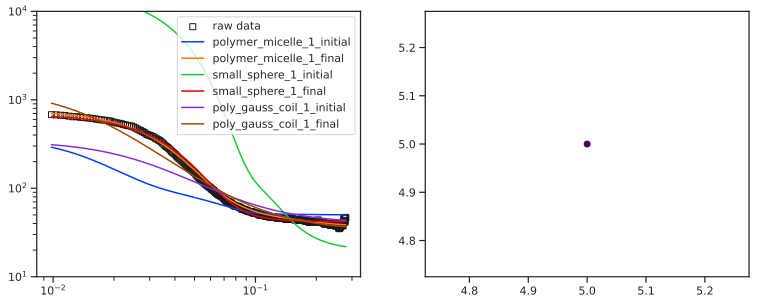


scale 10000.0
background 24.2325930028165
radius_core 54.47955519327156
rg 134.67293524224206
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 23.11393752950464
background 24.890058053096272
radius 46.2423725017654
radius_pd 0.30424848411661143
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 10000.0
background 18.14389655887715
rg 369.4276006633643


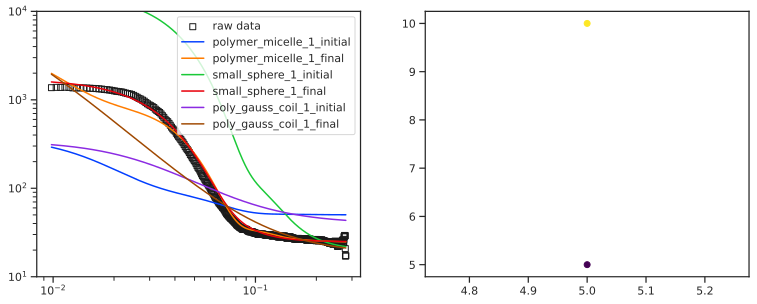


scale 10000.0
background 33.97449295369906
radius_core 109.88460930806227
rg 128.13537608305296
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 7.379448985263394
background 35.8588615792206
radius 122.8958986949626
radius_pd 0.3930105819443187
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 10000.0
background 32.38053105485396
rg 673.5440811154264


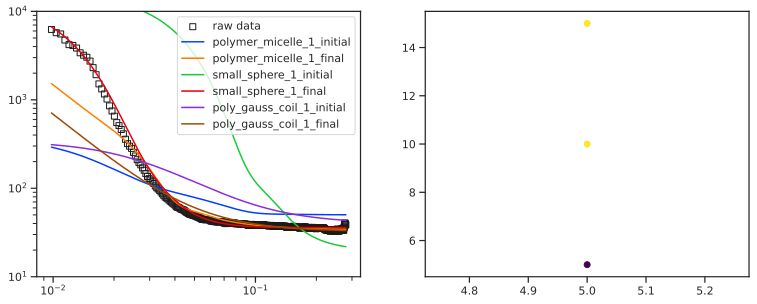


scale 486.3492765882306
background 55.60961416889919
radius_core 25.739716487913423
rg 133.2289778398709
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 9.578261885843986
background 55.515616317813716
radius 16.228277410801052
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 78.83883375679207
background 51.085510861083144
rg 34.27156175605189


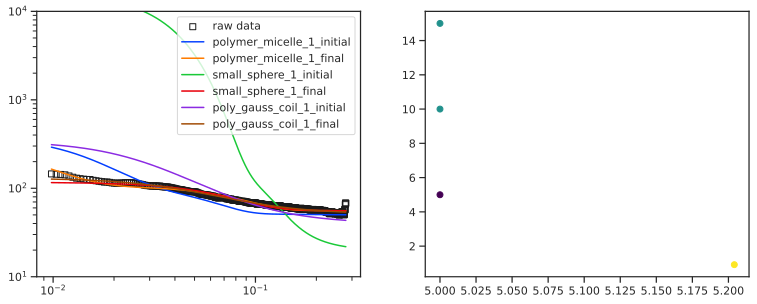


scale 535.3416623084598
background 54.511937499989344
radius_core 25.37905106026212
rg 140.74773329932376
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 11.188283042600673
background 54.34467893598861
radius 15.825448471129198
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 85.34483314296801
background 49.40121295596443
rg 33.25044709748326


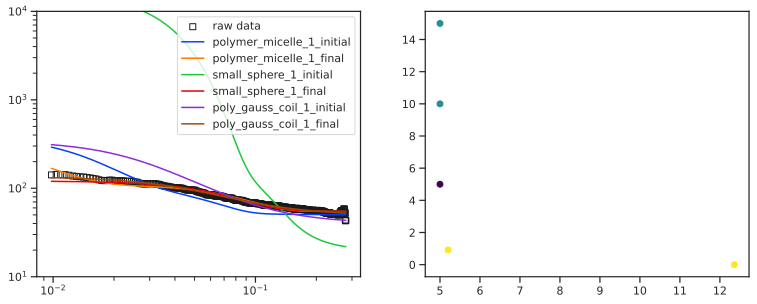


scale 124.88753773861893
background 51.01892789592792
radius_core 10.622519792082652
rg 16.302082148925553
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 9.802684366374503
background 55.14518378755273
radius 15.555194895398875
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 69.93343349849359
background 50.703871385401314
rg 31.682648847670418


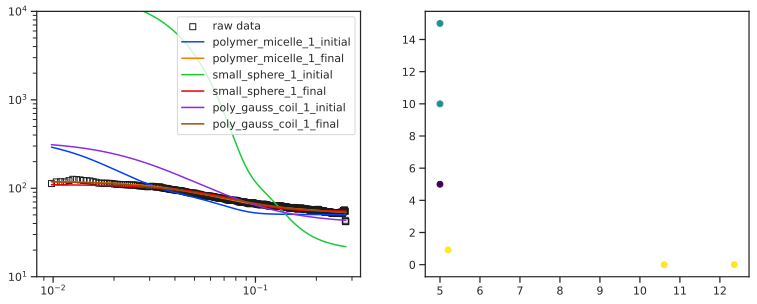


scale 499.127586278136
background 55.32677350698364
radius_core 25.310620857195953
rg 143.94010817561986
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 10.602652983533103
background 55.14408534393151
radius 15.68977487562409
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 78.29277545944728
background 50.44486915168491
rg 32.59022388766334


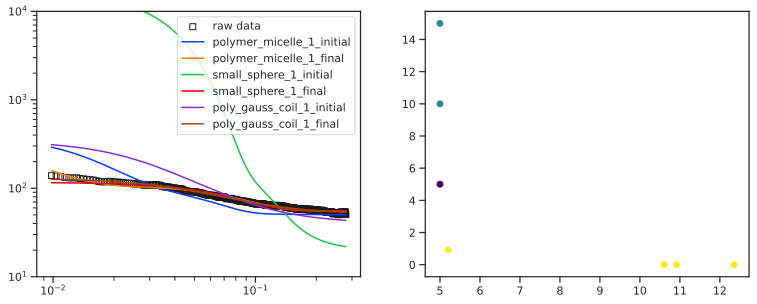


scale 449.2605523798703
background 55.44533846681796
radius_core 25.360984425208112
rg 125.48457895202593
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 8.785036190819975
background 55.49422892607041
radius 16.445907450924928
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 75.98033528366047
background 51.39528865312196
rg 35.20532422264764


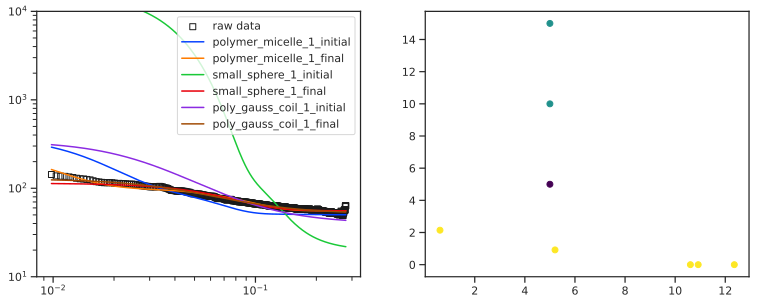


scale 10000.0
background 26.73949611456269
radius_core 57.173728484665105
rg 124.49725316018473
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 20.643638767387486
background 27.711726665738976
radius 50.1307838434395
radius_pd 0.28193988236908774
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 10000.0
background 20.90826568710044
rg 380.260876770697


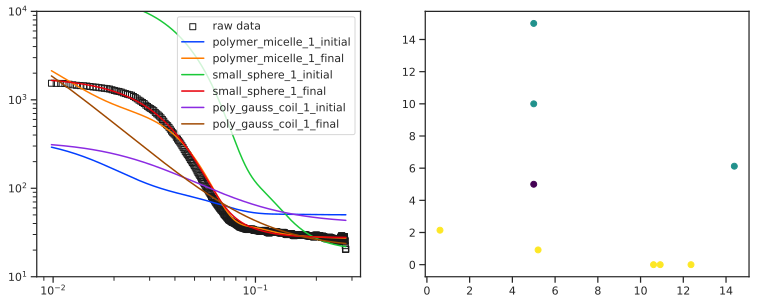


scale 1133.5281972162338
background 40.36064156446577
radius_core 37.575370482795016
rg 18.459735655741156
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 12.087595908142685
background 46.10593317710463
radius 31.600411015871984
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 1090.9971284339567
background 37.645272385009015
rg 115.3431470262085


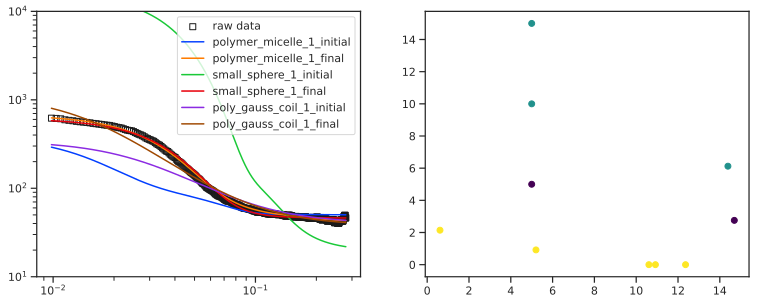


scale 550.6100331112156
background 52.89721161927571
radius_core 24.493228896226654
rg 135.15027393519117
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 12.770494538498033
background 52.72734475622355
radius 15.31569603153064
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 88.43060388317355
background 47.365059611901806
rg 31.914685113438605


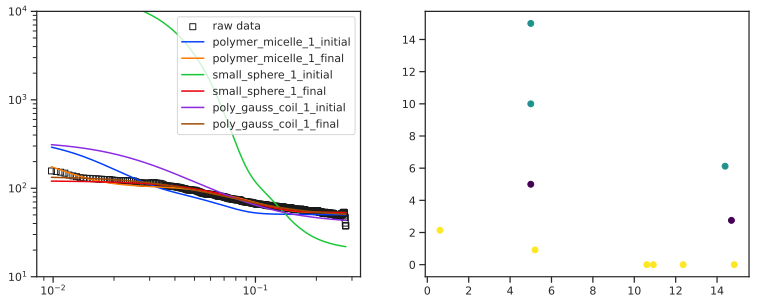


scale 571.7389597656728
background 52.164449305462554
radius_core 29.188198457632474
rg 24.284090999659686
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 7.513892069316823
background 54.860024178713616
radius 28.830384324771323
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 423.67754076649044
background 48.27515939232025
rg 82.10823332286638


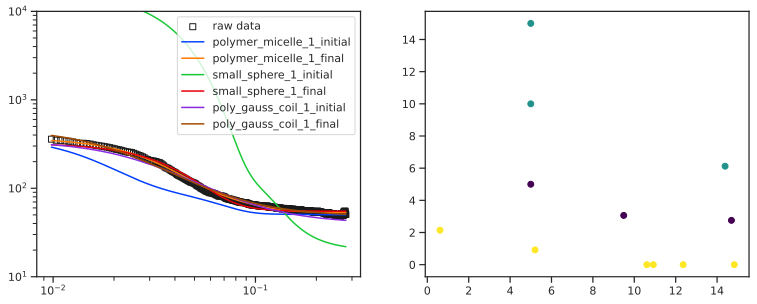


scale 1686.608686984928
background 30.48911835414941
radius_core 38.96091729700209
rg 19.2196268791134
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 16.905285758982014
background 38.3078499792852
radius 32.57698302465128
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 1987.2952262615674
background 29.15768618052003
rg 145.30240637362814


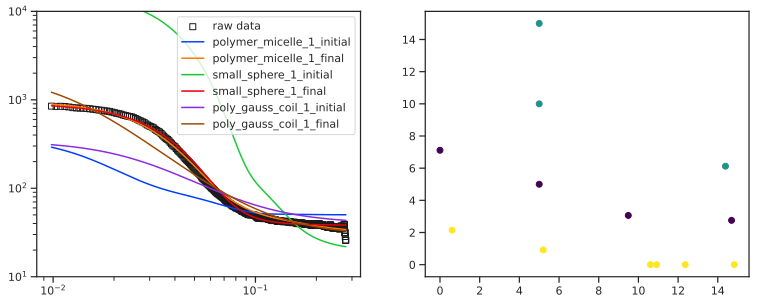


scale 491.2172752468921
background 55.80282290692189
radius_core 25.974117654986976
rg 141.9167590562253
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 9.473583845308339
background 55.6819858670033
radius 16.270688399257985
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 78.79732156874623
background 51.347992486201875
rg 34.63598878809941


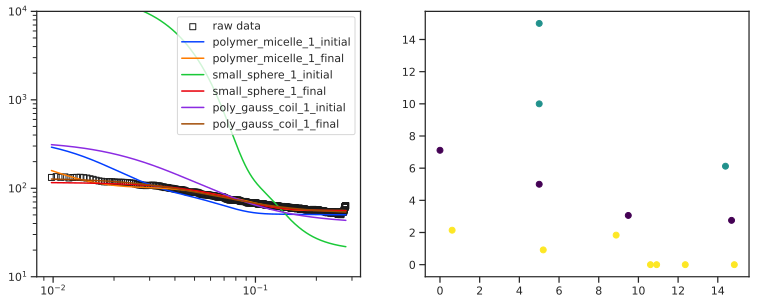


scale 138.49766465479658
background 52.18778503451927
radius_core 11.694478494613076
rg 17.10151770690811
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 9.454349472945283
background 56.06107980507876
radius 16.334827120785363
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 78.98939828588526
background 51.59376663386049
rg 34.31603584688628


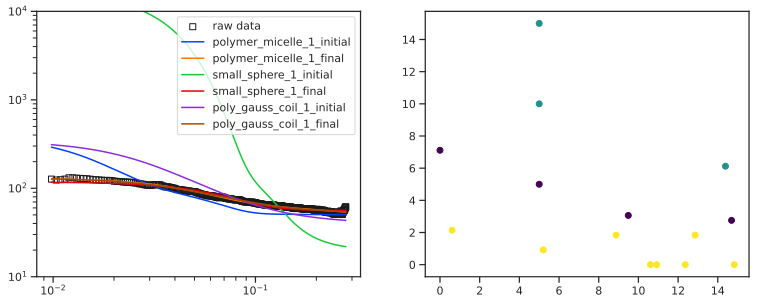


scale 295.9325792898769
background 53.07905967331237
radius_core 19.07559706303494
rg 25.815893143741743
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 5.9444745453925405
background 56.644580853141235
radius 25.004317799430165
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 191.55546304937164
background 51.521326244806644
rg 60.493434688041724


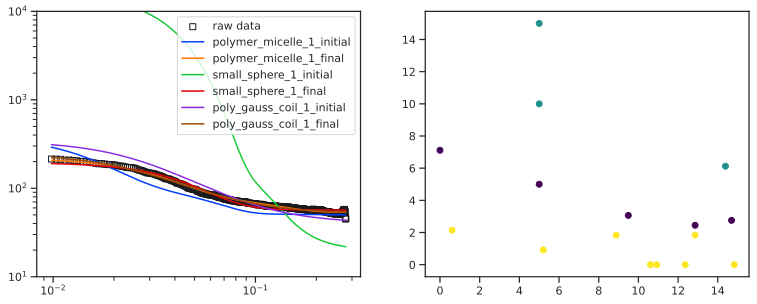


scale 136.74546945946219
background 52.38954047649699
radius_core 10.913599022957607
rg 17.45559397985093
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 9.590638825097194
background 56.75982740360561
radius 16.041801041457163
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 75.96998798948745
background 52.318320755405495
rg 33.48110746190384


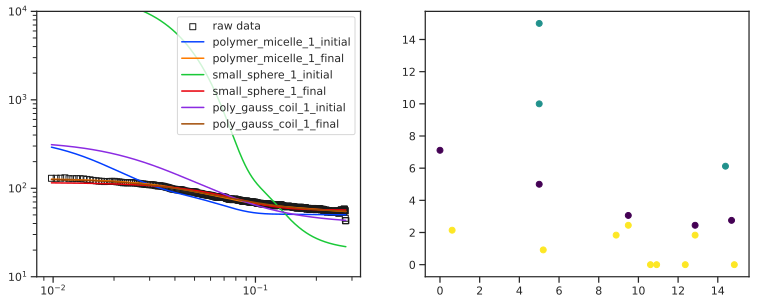


scale 175.53260462042152
background 51.87331305014481
radius_core 13.236095269505903
rg 21.79751543259749
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 7.300694819805746
background 56.064076626022874
radius 19.006449079778857
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 98.84335395328432
background 51.757233431146545
rg 42.139136725332484


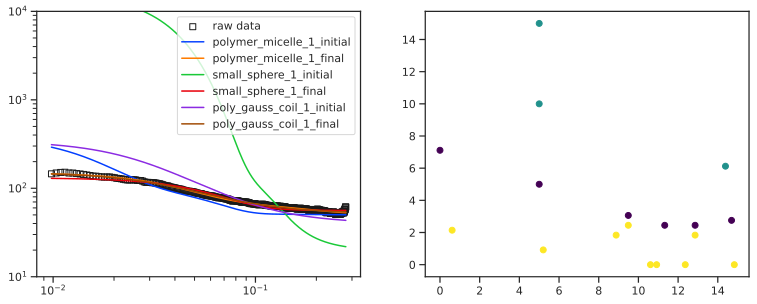


scale 468.5775393930817
background 55.401791142242764
radius_core 25.56913395960712
rg 143.68320343894717
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 9.429557603178152
background 55.29532591976179
radius 16.033593025456387
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 74.59419128149202
background 50.94889598297484
rg 33.50627110454355


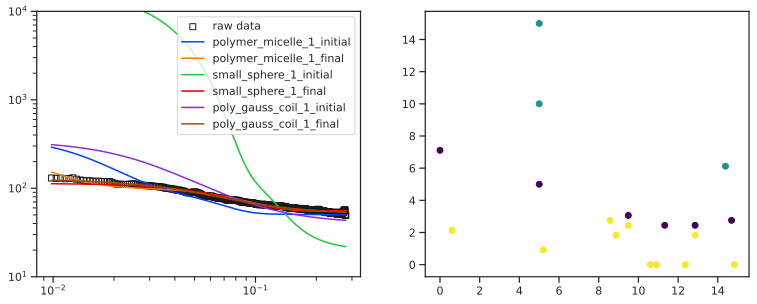


scale 238.04438926360802
background 53.407377894991214
radius_core 16.192772863075042
rg 23.768289989232393
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 7.154980915566846
background 57.0942463453153
radius 21.357826426029344
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 141.08010548692303
background 52.17986508229369
rg 49.56344117846948


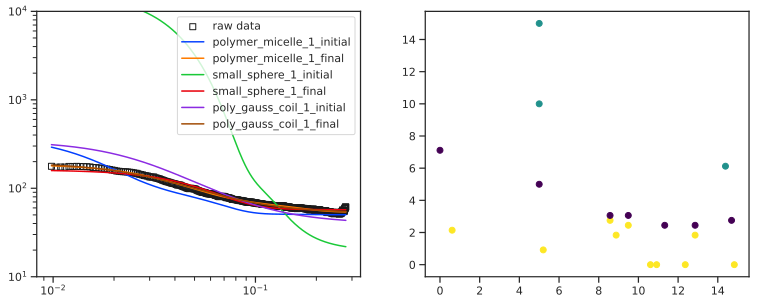


scale 923.1580765382524
background 45.283277771049036
radius_core 36.83635319948437
rg 18.24676092556852
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 10.217437880938213
background 50.06103395293207
radius 31.152540747572722
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 800.6630891081661
background 42.04024074319169
rg 102.47428178687515


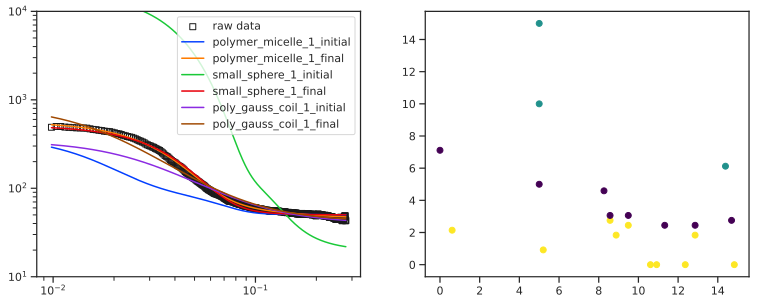


scale 1315.842367239586
background 37.26630648549274
radius_core 38.50040459692172
rg 17.49149968825318
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 13.902783853295102
background 44.32862690538257
radius 31.748457135625088
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 1295.7390359421183
background 35.25075166046444
rg 119.58043325290038


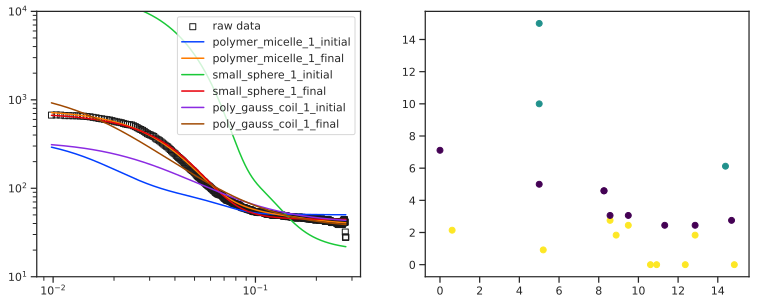


scale 470.7754977965402
background 57.26119014692327
radius_core 25.734637327465318
rg 141.59485462937968
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 9.264023838444702
background 57.16612102479533
radius 16.171496600467666
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 75.5846871986134
background 52.92037553702021
rg 34.229876348808645


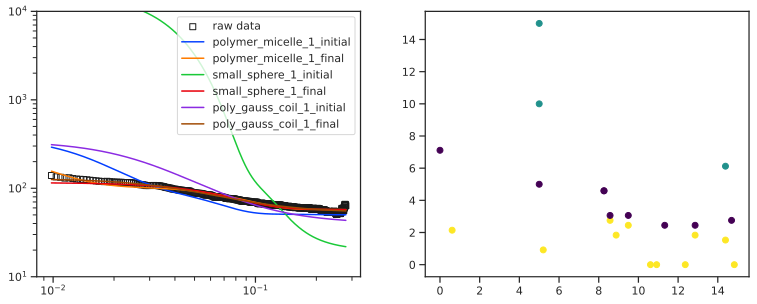


scale 443.40517883148044
background 51.26222045159795
radius_core 25.112098434123993
rg 25.02274565314779
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 7.037088562535974
background 54.000691623449804
radius 27.007495673974063
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 306.3125246799272
background 47.96454194044067
rg 71.58843853815301


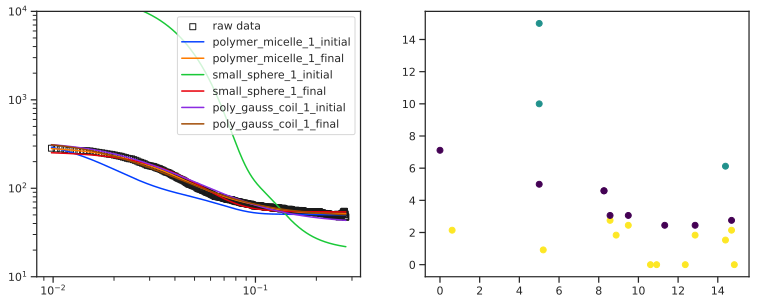


scale 614.853294724612
background 48.27930025853525
radius_core 30.74949040223251
rg 22.718313432732575
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 7.942359999180685
background 51.05620440011896
radius 29.160509858909606
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 468.29773560634726
background 44.319510237788165
rg 85.13578982036502


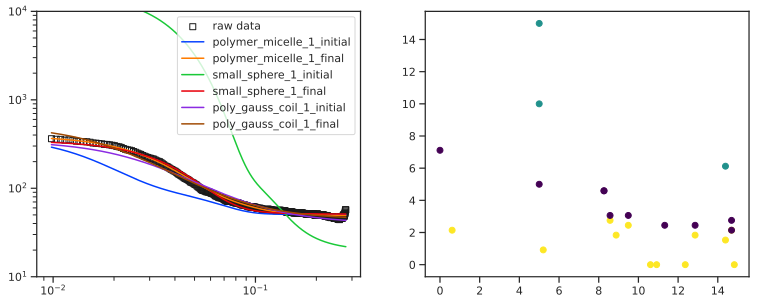


scale 361.78467400547925
background 51.25560966736186
radius_core 21.58987167297562
rg 26.22172521173156
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 6.460987758414193
background 54.42582964918993
radius 25.873053604939102
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 243.84729095058896
background 48.96155479121827
rg 66.3811544794739


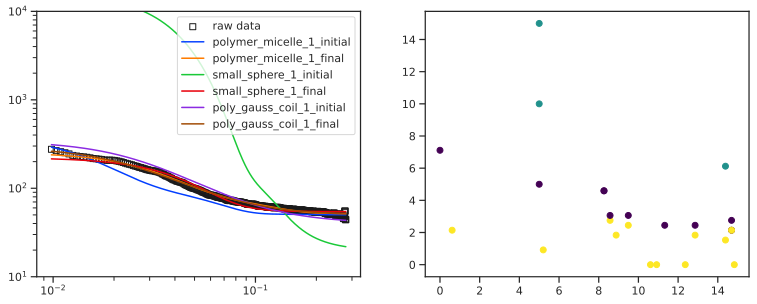


scale 478.31116348248804
background 51.81019621122772
radius_core 26.755132569552252
rg 24.339050606443518
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 7.164764218457331
background 54.42964779700063
radius 27.592348082693928
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 337.56597295740994
background 48.22627919766832
rg 74.62768927960495


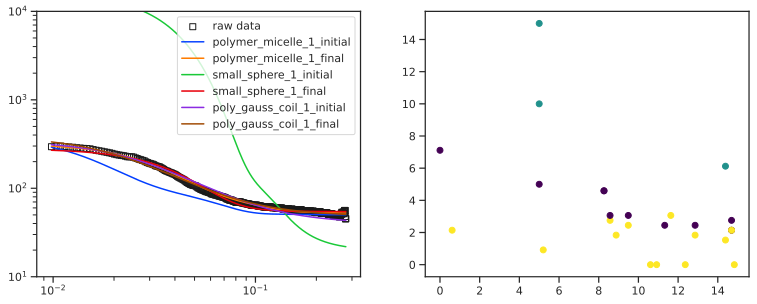


scale 411.3564554613765
background 51.60399948287898
radius_core 24.18941686061123
rg 25.638897042441464
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 6.66739699029158
background 54.372624110577334
radius 26.735873079661918
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 282.14433070170816
background 48.63840732473598
rg 70.44899369021067


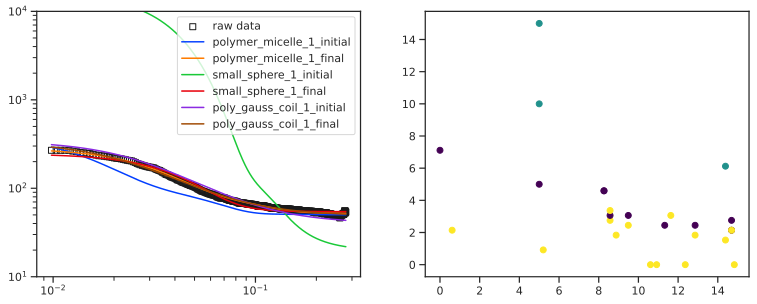


scale 209.53072876689168
background 49.95887060571056
radius_core 15.138324013777082
rg 25.402868700211812
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 5.55038606356385
background 54.11804908554997
radius 22.30086228228694
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 124.92997175228221
background 49.943203297834145
rg 51.85476736878594


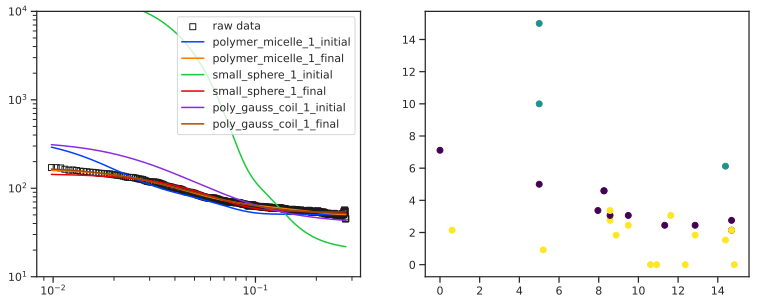


scale 286.8565081417108
background 50.97311991254274
radius_core 18.5725737034978
rg 24.798737165575414
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 6.800299439293731
background 54.31947646251119
radius 23.350068323782327
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 180.4056621877006
background 49.17243286080923
rg 56.66167491602548


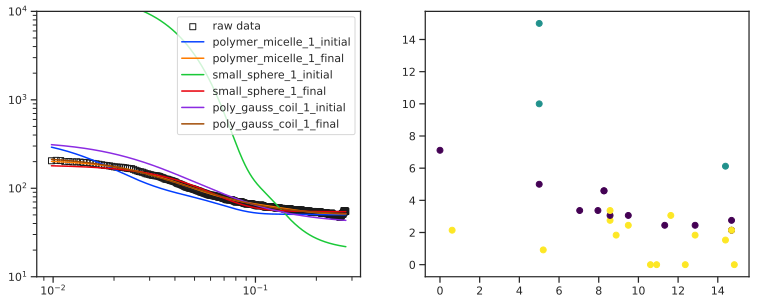


scale 132.09058337859182
background 50.710018926410214
radius_core 11.086133206672256
rg 17.930099727227116
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 9.120245378951552
background 54.737534564776155
radius 16.039226895730362
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 72.24744044292662
background 50.48577188674603
rg 33.39643910077358


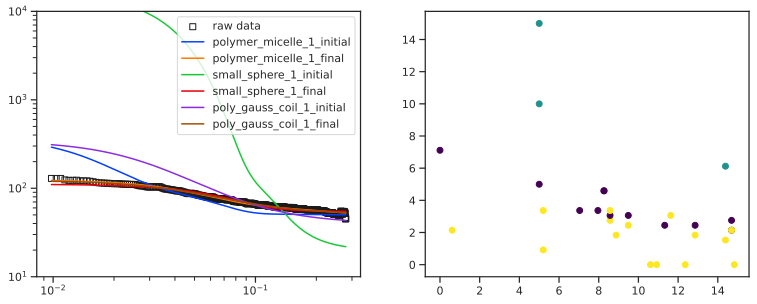


scale 271.2199577006202
background 52.12053449491918
radius_core 16.73247169043761
rg 25.90950469755276
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 6.203553251959064
background 56.478203831442855
radius 23.71777637084041
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 172.6659431812995
background 51.550494303139
rg 57.28136470186125


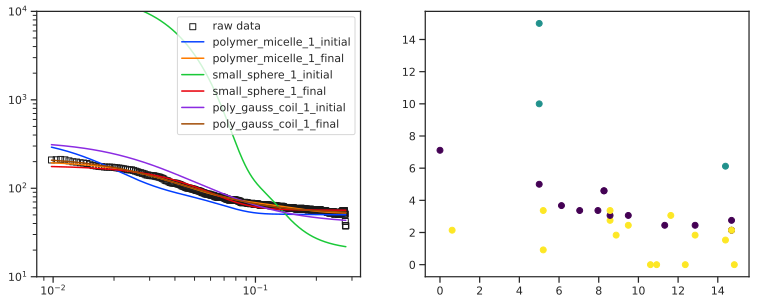


scale 478.8021253923293
background 51.19236380381055
radius_core 24.63942154835564
rg 24.602582583397286
sld_core 5.45
sld_corona 5.15
sld_solvent 6.36
scale 8.038479369117567
background 54.17745474425638
radius 26.491888130915687
radius_pd 0.5
radius_pd_type gaussian
radius_pd_n 15
sld 5.45
sld_solvent 6.36
i_zero 331.8655030760566
background 47.6179330925153
rg 70.4863354521316


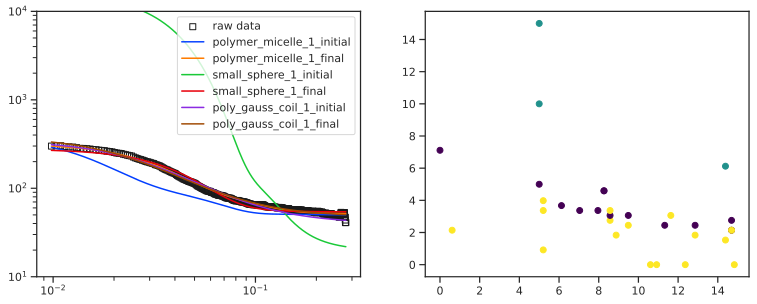

In [101]:
def label_items(arr):
    return np.unique(arr, return_inverse=True)
def label_key(arr):
    return np.unique(arr)

best_fits = []
chisqs = []
X = []
for idx in range(33):
    
    fit_method={'method':'lm',
                'steps':10000,
                'ftol': 1.5e-6,
                'xtol': 1.5e-6,
                'verbose':True
               }
    
    
    # data_ID = [f'data_{str(idx+1).zfill(3)}' for idx in range(len(model_ds.SAS))]
    # sasfit_client.enqueue(task_name="fit_models",data=[data[idx]],
    #                       data_ID=['data_1'],
    #                      fit_method=fit_method)
    
    
    # sasfit_client.enqueue(task_name='build_report')
    # report_json = sasfit_client.get_driver_object('report')
    
    fit_method= report_json['fit_method']
    print()
    model_starts = report_json['model_inputs']
    fit_results = report_json['best_fits']['model_idx'][idx]
    empty_data = sasmodels.data.empty_data1D(np.logspace(np.log10(model_ds.q.values.min()),
                                                         np.log10(model_ds.q.values.max()),
                                                         1000
                                                        ))
    # bf = report_json['best_fits'][f'data_{str(idx+1).zfill(3)}']
    # best_fits.append(bf['model_name'])
    # chisqs.append(bf['lowest_chisq'])
    # best_fits.append(report_json['best_fits'][idx])
    best_fits.append(fit_results)
    X.append([model_ds.benzyl_alcohol_solute.values[idx],model_ds.phenol_solute.values[idx]])
    
    
    fig,ax = plt.subplots(1,2,figsize=(12.8,4.8))
    ax[0].scatter(q,model_ds.SAS[idx].values,label='raw data',color='k',marker='s',facecolors='none')
    for mdx in range(len(model_starts)):
        init_model = model_starts[mdx]
        fit_model = report_json['model_fits'][idx][mdx]
        # print(init_model)
        # print(fit_model)
        # print()
        init_model = sas_wrapper(
            name=init_model['name'],
            sasmodel_type=init_model['sasmodel'],
            parameters=init_model['fit_params'],
            empty_data = empty_data,
            resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
            )
        
        #fit model parameters are not the same format as the initialized model. rebuild an unbounded parameters
        #dictionary this way
        
        params_final = {}
        for key in list(fit_model['output_fit_params']):
            print(key, fit_model['output_fit_params'][key]['value'])
            params_final[key] = {'value':fit_model['output_fit_params'][key]['value'], 'bounds':None}
        fit_model = sas_wrapper(
            name=fit_model['name'],
            sasmodel_type=fit_model['sasmodel'],
            parameters=params_final,
            empty_data = empty_data,
            resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
            )
        
        
        ax[0].plot(init_model.model_q, init_model.model_I, label=f'{init_model.name}_initial')
        ax[0].plot(fit_model.model_q, fit_model.model_I, label=f'{fit_model.name}_final')
        ax[0].set(
            xscale='log',
            yscale='log',
            ylim= (1e1,1e4)
            )
        ax[0].legend()
    _, clss = label_items(best_fits)
    key = label_key(best_fits)
    ax[1].scatter(np.array(X)[:,0],np.array(X)[:,1],c=clss,cmap='viridis')
    plt.show(fig)
    plt.close(fig)

In [51]:
X_train = np.array([model_ds.benzyl_alcohol_solute.values,model_ds.phenol_solute.values]).T
Y_train = []
for row in 

[0,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 2]

## Serial Fitting

In [ ]:
sasfit_client.enqueue(task_name='build_report')
report_json = sasfit_client.get_driver_object('report')
report_json
fit_method= report_json['fit_method']
model_starts = report_json['model_inputs']
fit_results = report_json['model_fits']
empty_data = sasmodels.data.empty_data1D(np.logspace(np.log10(model_ds.q.values.min()),
                                                     np.log10(model_ds.q.values.max()),
                                                     1000
                                                    ))
for idx in range(len(model_ds.SAS.values)):
    fig,ax = plt.subplots(1,2,figsize=(12.8,4.8))
    ax[0].scatter(q,model_ds.SAS[idx].values,label='raw data')
    for mdx in range(len(model_starts)):
        init_model = model_starts[mdx]
        fit_model = fit_results[mdx]
        # print(init_model)
        # print(fit_model)
        # print()
        init_model = sas_wrapper(
            name=init_model['name'],
            sasmodel_type=init_model['sasmodel'],
            parameters=init_model['fit_params'],
            empty_data = empty_data,
            resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
        )
        
        #fit model parameters are not the same format as the initialized model. rebuild an unbounded parameters
        #dictionary this way
        
        params_final = {}
        for key in list(fit_model[mdx]['output_fit_params']):
            params_final[key] = {'value':fit_model[mdx]['output_fit_params'][key]['value'], 'bounds':None}
        fit_model = sas_wrapper(
            name=fit_model[mdx]['name'],
            sasmodel_type=fit_model[mdx]['sasmodel'],
            parameters=params_final,
            empty_data = empty_data,
            resolution = sasmodels.resolution.Pinhole1D(empty_data.x, empty_data.x*0.15)
        )
        
        
        ax[0].plot(init_model.model_q, init_model.model_I, label=f'{init_model.name}_initial')
        ax[0].plot(fit_model.model_q, fit_model.model_I, label=f'{fit_model.name}_final')
        ax[0].set(
            xscale='log',
            yscale='log'
        )
        ax[0].legend()
    plt.show(fig)
    plt.close(fig)

[0.10901291008439683, 0.4666097823923236, 1.4276706821023006] 0 polymer_micelle_1
[1.5796703532257839, 2.8008062189137344, 7.610963666871448] 0 polymer_micelle_1
[240.50111473440015, 2.6669240807387435, 4.2167754516434215] 1 small_sphere_1
[589.0080232106926, 19.82083824548737, 6.921357775311741] 2 poly_gauss_coil_1
[551.4233011171323, 12.986913851906541, 6.803085921655831] 2 poly_gauss_coil_1
[706.1922602934334, 6.028173140784286, 6.859588526077948] 1 small_sphere_1
[601.1235011580019, 3.318372031259583, 6.586875424755204] 1 small_sphere_1
[618.2655813773314, 0.991923320840426, 6.116537457279797] 1 small_sphere_1
[2.147048455788609, 12.365805119131792, 41.59374120827924] 0 polymer_micelle_1
[31.4664937425923, 3.8337061648000783, 10.477807592361469] 1 small_sphere_1
[378.5663401558229, 11.24442383777559, 6.139409342537034] 2 poly_gauss_coil_1
[83.69993058363599, 4.49672756001287, 8.846923893896859] 1 small_sphere_1
[8.701593251151465, 0.7618174531008985, 15.304630253281633] 1 small_sph

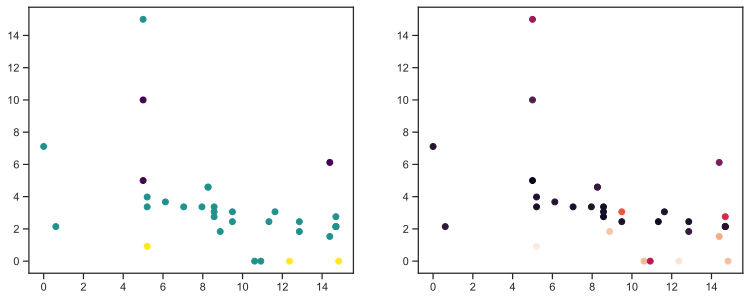

In [506]:
labels = []
ID = []
chisqr = []

for fit in sasfit_client.get_driver_object('results'):
    all_chisq = [fit[mdx]['chisq'] for mdx in range(len(fit))]
    best_idx = np.nanargmin(all_chisq)
    best_model = fit[best_idx]['name']
    print(all_chisq,best_idx,best_model)
    labels.append(best_model)
    ID.append(best_idx)
    chisqr.append(np.min(all_chisq))

x,y = model_ds.benzyl_alcohol_solute.values, model_ds.phenol_solute.values
# x,y = x[:3],y[:3]
fig,ax = plt.subplots(1,2,figsize=(12.8,4.8))
ax[0].scatter(x,y,c=ID,label=labels,cmap='viridis')
ax[1].scatter(x,y,c=chisqr)

In [507]:
test = sasfit_client.get_config('model_inputs')